# 本章摘要

**本章包括以下内容：**
- 构建Keras模型的3种方法，即序贯模型、函数式API和模型子类化
- 使用Keras内置的训练循环和评估循环
- 使用Keras回调函数来自定义训练
- 使用TensorBoard监控训练指标和评估指标
- 从头开始编写训练循环和评估循环

# Keras工作流程

Keras API的设计原则是**渐进式呈现复杂性**。<p>
Keras 提供了**一系列工作流程**。既有非常简单的工作流程，也有非常灵活的工作流程。

# 构建Keras模型的不同方法

在Keras中，构建模型可以使用以下3个API：
- **序贯模型**（sequential model）：这是最容易理解的API。它本质上是Python列表，仅限于层的简单堆叠。
- **函数式API**（functional API）：专注于类似图的模型结构。它在可用性和灵活性之间找到了很好的平衡点，因此是构建模型最常用的API。
- **模型子类化**（model subclassing）：是一个底层选项，可以从头开始自己编写所有内容。<p>

![Keras渐进式呈现复杂性](images/Keras渐进式呈现复杂性.png)

## 序贯模型

In [22]:
# 使用Sequential类构建模型
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])
# 使用add()方法
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
# 只有在数据上调用模型或者调用模型的build()方法并给定输入形状时，模型才有权重
model.build(input_shape=(None, 3))
model.weights

[<tf.Variable 'dense_11/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.01615956, -0.06874424,  0.00115848, -0.01091331, -0.04483801,
         -0.04789981,  0.03007901, -0.06900203, -0.1380572 ,  0.12745562,
         -0.23870517, -0.14678456, -0.1876929 , -0.25432742, -0.14858615,
          0.24506742,  0.2848544 ,  0.2833345 ,  0.01095375,  0.21575624,
          0.11743551,  0.2803548 ,  0.02765855,  0.29020333,  0.04580933,
          0.10731539,  0.2661476 ,  0.14312902, -0.1966697 , -0.2872001 ,
          0.12172163, -0.03410977,  0.13054127,  0.0606257 , -0.18438274,
         -0.10214819, -0.07672796, -0.01987404,  0.07959318,  0.16681272,
          0.03780529,  0.14951974, -0.08676931, -0.15649359,  0.07808846,
         -0.15318507, -0.14740764, -0.10751787,  0.04491299, -0.26342505,
          0.00499746,  0.2355125 , -0.16051902,  0.04607168, -0.04732111,
         -0.08319381, -0.15369698, -0.189175  , -0.2719413 , -0.23080415,
          0.08646289,  0.261347  , -0.2580

### 使用summary()方法显示模型内容

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 使用name参数命名模型和层

In [4]:
model = keras.Sequential(name='my_example_model')
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build(input_shape=(None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 提前声明模型的输入形状，随时查看模型变化

In [5]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


## 函数式API

序贯模型易于使用，但使用范围非常有限：**它只能表示具有单一输入和单一输出的模型，按顺序逐层进行处理。** 想要使用其他类型的模型，就可以使用函数式API构建模型。

### 简单示例

In [6]:
# 首先声明一个Input：Input对象保存了关于模型将处理的数据形状和数据类型的信息。Input对象叫作符号张量
inputs = keras.Input(shape=(3,), name="my_input")
# 接下来，创建一个层，并在输入上调用Input层
features = layers.Dense(64, activation="relu")(inputs)
# 得到最终输出之后，在Model构造函数中指定输入和输出，将模型实例化
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)
# 查看模型结构
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                256       
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 多输入、多输出模型

假设要构建一个系统，按优先级对客户支持工单进行排序，并将工单转给相应的部分。这个模型有3个输入：
- 工单标题（文本输入）
- 工单文本正文（文本输入）
- 用户添加的标签（分类输入，假定为one-hot编码） <p>

将文本输入编码为1和0组成的数组，数组大小为vocabulary_size。 <p>
模型还有2个输出：
- 工单的优先级分数，它是介于0和1之间的标量（sigmoid输出）
- 应处理工单的部分（对所有部分做softmax）

In [4]:
from tensorflow.keras import layers
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# 定义模型输入，有三个输入需要定义三个Input对象
title_input = keras.Input(shape=(vocabulary_size, ), name="title")
text_body_input = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags_input = keras.Input(shape=(num_tags, ), name="tags")
# 通过拼接将输入特征组合成张量features
features = layers.Concatenate()([title_input, text_body_input, tags_input])
features = layers.Dense(64, activation="relu")(features)
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)
model = keras.Model(inputs=[title_input, text_body_input, tags_input], outputs=[priority, department])

2024-09-02 21:00:17.450414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 训练一个多输入、多输出模型

In [5]:
import numpy as np

num_samples = 1280
# 虚构输入数据
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))
# 虚构目标数据
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit(
    [title_data, text_body_data, tags_data],
    [priority_data, department_data],
    epochs=1)

model.evaluate(
    [title_data, text_body_data, tags_data],
    [priority_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 2ms/step


#### 通过给定输入和目标组成的字典来训练模型

In [6]:
model.compile(
    optimizer="rmsprop",
    loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
    metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data},
    epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data})
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 2ms/step


### 获取层的连接方式

函数式模型是一种图数据结构。这便于查看层与层之间是如何连接的，并重复使用之前的图节点（层输出）作为新模型的一部分。<p>
**思考深度神经网络时使用的“思维模式”：** 由层构成的图。 <p>
两个重要的用处：
- 模型可视化
- 特征提取

In [7]:
from tensorflow import keras 
# 可视化上述模型的连接方式（模型的拓扑结构）
keras.utils.plot_model(model, to_file="ticker_classifier.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
# 将模型每一层的输入形状和输出形状添加到这张图中
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### 检索函数式模型某一层的输入或输出

In [9]:
# 检索函数式模型某一层的输入或输出
model.layers

In [10]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [11]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

#### 特征提取

特征提取，重复使用模型的中间特征来创建新模型。<p>
假设，对前一个模型增加一个输出 —— 估算某个问题工单的解决时长，这是一种难度评分。实现方法是利用包含3个类别的分类层，这3个类别分别是 “快速”，“中等”，“困难”。无须从头开始重新创建和训练模型。可以从前一个模型的中间特征开始。

In [12]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)
new_model = keras.Model(inputs=[title_input, text_body_input, tags_input], outputs=[priority, department, difficulty])

In [13]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## 模型子类化

构建模型的最高级方法：**模型子类化**，也就是将Model类子类化：<p>
- 在`__init__()`方法中，定义模型将使用的层；
- 在`call()`方法中，定义模型的前向传播，重复使用之前创建的层；
- 将子类实例化，并在数据上调用，从而创建权重。

### 将前一个例子重新实现为Model子类

In [14]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        # 调用super()构造函数
        super().__init__()
        # 在构造函数中定义子层
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    # 在call()方法中定义前向传播
    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

#### 将Model子类实例化

In [15]:
model = CustomerTicketModel(num_departments=4)
priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

### Layer子类与Model子类之间的区别？

- “层”（layer）是用来创建模型的组件；
- “模型”（model）是高阶对象，用于训练、导出进行推理等；
- 总结：Model有`fit()`、`evaluate()`和`predict()`等方法，而Layer没有。

### 编译和训练Model子类

In [16]:
model.compile(optimizer="rmsprop", 
              loss=["mean_squared_error", "categorical_crossentropy"],  # 参数loss和metrics的结构必须与call()返回的内容完全匹配
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},  # 输入数据的结构必须与call()方法的输入完全匹配
          [priority_data, department_data],  # 目标数据的结构必须与call()方法返回的内容完全匹配
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               [priority_data, department_data])

priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 2ms/step


### Model子类可以做什么

模型子类化是最灵活的模型构建方法。可以构建无法表示为层的**有向无环图的模型**。比如：call()方法在for循环中使用层，甚至递归调用这些层。

### 注意：Model子类不能做什么

对于子类化模型，需要负责更多的模型逻辑，**犯错的可能性会更大**。

#### 函数式模型和子类化模型本质上的区别

- 函数式模型是一种数据结构 ———— 它是由层构成的图，可以查看、检查和修改它。
- 子类化模型是一段字节码 ———— 它是带有call()方法的Python类，其中包含原始代码。

## 混合使用不同的组件

### 创建一个包含子类化模型的函数式模型

In [17]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)


inputs = keras.Input(shape=(3, ))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

### 创建一个包含函数式模型的子类化模型

In [18]:
inputs = keras.Input(shape=(64, ))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)


class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

# 使用内置的训练循环和评估循环

## 标准工作流程

1. **compile()：编译模型**
2. **fit()：训练模型**
3. **evaluate()：评估模型**
4. **predict()：预测推理**

In [19]:
from tensorflow.keras.datasets import mnist

# 创建模型
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28, ))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

# 加载数据，保留一部分数据用于验证
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]
model = get_mnist_model()
# 编译模型，complie()，指定模型的优化器、需要最小化的损失函数和需要监控的指标
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])
# 使用fit()训练模型，可以选择提供验证数据来监控模型在前所未见的数据上的性能
model.fit(train_images, 
          train_labels, 
          epochs=3, 
          validation_data=(val_images, val_labels))
# 使用evaluate()计算模型在新数据上的损失和指标
test_metrics = model.evaluate(test_images, test_labels)
# 使用predict()计算模型在新数据上的分类概率
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2951 - accuracy: 0.9127 - val_loss: 0.1445 - val_accuracy: 0.9587
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1669 - accuracy: 0.9533 - val_loss: 0.1192 - val_accuracy: 0.9675
Epoch 3/3
313/313 [==============================] - 0s 1ms/step


## 编写自定义指标

指标是衡量模型性能的关键，尤其是衡量模型在训练数据上的性能与在测试数据上的性能之间的差异。<p>
常用的分类指标和回归指标内置于**keras.metrics**模块中。

### 如何编写自定义指标

Keras指标是keras.metrics.Metrics类的子类。与层相同的是：指标具有一个存储在TensorFlow变量中的内部状态。与层不同的是，这些变量无法通过反向传播进行更新，必须编写状态更新逻辑。这一逻辑由`update_state()`方法实现。

### 编写自定义指标：用于衡量均方根误差(RMSE)

#### 通过将Metric类子类化来实现自定义指标

In [23]:
import tensorflow as tf

# 将Metric类子类化
class RootMeanSquaredError(keras.metrics.Metric):
    # 在构造函数中定义状态变量。与层一样，可以访问add_weight()方法
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    # 为了匹配MNIST模型，需要分类预测值与整数标签
    def update_state(self, y_true, y_pred, sample_weight=None):
        # 在update_state()中实现状态更新逻辑。y_true参数是一个数据批量对应的目标(或标签)，y_pred则表示相应的模型预测值。
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # 使用result()方法返回指标的当前值
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # 提供一个重置指标状态的方法
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

#### 测试自定义的RMSE指标

In [25]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2953 - accuracy: 0.9122 - rmse: 7.1818 - val_loss: 0.1713 - val_accuracy: 0.9507 - val_rmse: 7.3600
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1669 - accuracy: 0.9530 - rmse: 7.3544 - val_loss: 0.1189 - val_accuracy: 0.9673 - val_rmse: 7.4021
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1001 - accuracy: 0.9739 - rmse: 7.4346


## 使用回调函数

回调函数是一个对象，它在调用`fit()`时被传入模型，并在训练过程中的不同时间点被模型调用。回调函数可以访问关于模型状态与模型性能的所有可用数据，还可以采用以下行动：
- 中断训练
- 保存模型
- 加载一组不同的权重或者改变模型的状态 <p>

**回调函数的一些用法示例如下：**
- **模型检查点**(model checkpointing)：在训练过程中的不同时间点保存模型的当前状态。
- **提前终止**(early stopping)：如果验证损失不再改善，则中断训练。
- **在训练过程中动态调节某些参数值**：比如调节优化器的学习率。
- **在训练过程中记录训练指标和验证指标，或者将模型学到的表示可视化(这些表示在不断更新)**：`fit()`进度条实际上就是一个回调函数。 <p>

keras.callbacks模块包含许多内置的回调函数，下面列出一些：
- `keras.callbacks.ModelCheckpoint`
- `keras.callbacks.EarlyStopping`
- `keras.callbacks.LearningRateScheduler`
- `keras.callbacks.ReduceLROnPlateau`
- `keras.callbacks.CSVLogger`

### 回调函数EarlyStopping和ModelCheckpoint

如果监控的目标指标在设定的轮数内不再改善，那么可以用EarlyStopping回调函数中断训练。这个回调函数通常与ModelCheckpoint结合使用，后者可以在训练过程中不断保存模型。

#### 在fit()方法中使用callbacks参数

In [27]:
# 通过fit()的callbacks参数将回调函数传入模型中，该参数接收一个回调函数列表，可以传入任意数量的回调函数
callbacks_list = [
    # 如果不改善，则中断训练
    keras.callbacks.EarlyStopping(
        # 监控模型的验证精度
        monitor="val_accuracy",
        # 如果精度在两轮内都不再改善，则中断训练
        patience=2
    ),
    # 在每轮过后保存当前权重
    keras.callbacks.ModelCheckpoint(
        # 模型文件的保存路径
        filepath="checkpoint_path.keras",
        # 这两个参数的含义是，只有当val_loss改善时，才会覆盖模型文件
        monitor="val_loss",
        save_best_only=True
    )
]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, 
          train_labels, 
          epochs=10, 
          callbacks=callbacks_list, 
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2988 - accuracy: 0.9112 - val_loss: 0.1647 - val_accuracy: 0.9534
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1672 - accuracy: 0.9538 - val_loss: 0.1268 - val_accuracy: 0.9657
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1383 - accuracy: 0.9632 - val_loss: 0.1105 - val_accuracy: 0.9712
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1282 - accuracy: 0.9670 - val_loss: 0.1147 - val_accuracy: 0.9712
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1185 - accuracy: 0.9701 - val_loss: 0.1088 - val_accuracy: 0.9744
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1121 - accuracy: 0.9728 - val_loss: 0.1033 - val_accuracy: 0.9773
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1031 - accuracy: 0.9753 - val_loss: 0.1253 - val_accuracy:

#### 加载已保存的模型

In [28]:
model = keras.models.load_model("checkpoint_path.keras")

## 编写自定义回调函数

自定义回调函数的实现方式是将`keras.callbacks.Callback`类子类化。可以实现下列方法，在训练过程中的不同时间点被调用。<p>
```
on_epoch_begin(epoch, logs)  # 在每轮开始时被调用
on_epoch_end(epoch, logs)  # 在每轮结束时被调用
on_batch_begin(batch, logs)  # 在处理每个批量之前被调用
on_batch_end(batch, logs)  # 在处理每个批量之后被调用
on_train_begin(logs)  # 在训练开始时被调用
on_train_end(logs)  # 在训练结束时被调用
```
<p>

上述方法都用到了参数 **logs**。这个参数是一个字典，它包含前一个批量、前一个轮次或前一次训练的信息，比如：训练指标和验证指标。

### 通过对Callback类子类化来创建自定义回调函数

In [31]:
# 在训练过程中保存每个批量损失值组成的列表，还在每轮结束时保存这些损失值组成的图
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, epoch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses, label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2957 - accuracy: 0.9121 - val_loss: 0.1459 - val_accuracy: 0.9594
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1668 - accuracy: 0.9528 - val_loss: 0.1286 - val_accuracy: 0.9661
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1398 - accuracy: 0.9630 - val_loss: 0.1163 - val_accuracy: 0.9694
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1240 - accuracy: 0.9678 - val_loss: 0.1185 - val_accuracy: 0.9714
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1203 - accuracy: 0.9702 - val_loss: 0.1058 - val_accuracy: 0.9749
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1075 - accuracy: 0.9735 - val_loss: 0.1140 - val_accuracy: 0.9753
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1041 - accuracy: 0.9749 - val_loss: 0.1122 - val_accuracy:

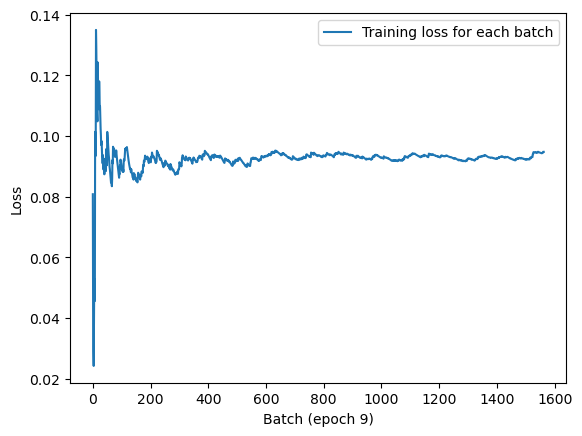

In [30]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, callbacks=[LossHistory()], validation_data=(val_images, val_labels))

## 利用TensorBoard进行监控和可视化

TensorBoard是一个基于浏览器的应用程序，可以在本地运行。它是在训练过程中监控模型的最佳方式。利用TensorBoard，可以做以下工作：
- 在训练过程中以可视化方式监控指标；
- 将模型架构可视化；
- 将激活函数和梯度的直方图可视化；
- 以三维形式研究嵌入 <p>

要将TensorBoard与Keras模型和`fit()`方法一起使用，最简单的方式就是使用`keras.callbacks.TensorBoard`回调函数

In [33]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(
    log_dir="./chapter07_tensorboard_log_dir"
)
model.fit(train_images, 
          train_labels, 
          epochs=10, 
          validation_data=(val_images, val_labels), 
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2941 - accuracy: 0.9135 - val_loss: 0.1457 - val_accuracy: 0.9595
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1663 - accuracy: 0.9532 - val_loss: 0.1260 - val_accuracy: 0.9669
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1419 - accuracy: 0.9622 - val_loss: 0.1172 - val_accuracy: 0.9676
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1290 - accuracy: 0.9669 - val_loss: 0.1179 - val_accuracy: 0.9722
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1197 - accuracy: 0.9698 - val_loss: 0.1068 - val_accuracy: 0.9743
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1100 - accuracy: 0.9730 - val_loss: 0.1118 - val_accuracy: 0.9758
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1042 - accuracy: 0.9755 - val_loss: 0.1111 - val_accuracy:

In [41]:
%reload_ext tensorboard
%tensorboard --logdir=./chapter07_tensorboard_log_dir --verbosity=1

ERROR: Failed to launch TensorBoard (exited with -4).

# 编写自定义的训练循环和评估循环

`fit()`工作流程在易用性和灵活性之间实现了很好的平衡。但它无法实现深度学习研究人员想做的一切事情。<p>
**内置的fit()缺点：** 内置`fit()`工作流程只针对**监督学习**。监督学习是指：已知与输入数据相关联的**目标**，将损失计算为这些目标和模型预测值的函数。但**非监督学习**，如**生成式学习**、**自监督学习**和**强化学习**。<p>
编写自定义的训练逻辑，典型的训练循环包含以下内容：
1. 在梯度带中运行前向传播（计算模型输出），得到当前数据批量的损失值；
2. 检索损失相当于模型权重的梯度；
3. 更新模型权重，以降低当前数据批量的损失值。

## 训练与推断

在典型训练循环中，步骤1（前向传播）是通过`predicitions = model(inputs)`完成的，步骤2（检索梯度带计算的梯度）是通过`gradients = tape.gradient(loss, model.weights)`完成的。在一般情况下，**还有两个细节需要考虑**：
1. 某些Keras层（如：Dropout层），在训练过程和推断过程中具有不同的行为。这些层的call()方法中有一个名为`training`的bool参数。调用`dropout(inputs, training=True)`将舍弃一些激活单元，而调用`dropout(inputs, training=False)`则不会舍弃。在前向传播中调用Keras模型时，**一定要记得传入`training=True`**。即前向传播应该变成`predictions = model(inputs, training=True)`。
2. 检索模型权重的梯度时，不应该使用`tape.gradients(loss, model.weights)`，而应使用tape.gradients(loss, model.trainable_weights)。层和模型具有以下两种权重：
    - **可训练权重（trainable weight）**：通过反向传播对这些权重进行更新，以便将模型损失最小化。比如：Dense层的核和偏置就是可训练权重。
    - **不可训练权重（non-trainable weight）**：在前向传播过程中，这些权重所在的层对它们进行更新。如果像自定义一层，用于记录该层处理了多少个批量，那么这一信息需要存储在一个不可训练权重中。每处理一个批量，该层将计数器加1。

### 监督学习的训练步骤

In [ ]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
        gradients = tape.gradients(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(model.trainable_weights, gradients))

## 指标的低阶用法

在低阶训练循环中，可能会用到Keras指标（无论是自定义还是内置）。指标API：只需要对每一个目标和预测值组成的批量调用`update_state(y_true, y_pred)`，然后使用`result()`查询当前指标值。

In [43]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


In [44]:
# 追踪某个标量值（如：模型损失）的均值
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


想要重置当前结果（在一轮训练开始或评估开始时），**记得使用`metric.reset_state()`** 。

## 完整的训练循环和评估循环

将前向传播、反向传播和指标跟踪组合成一个类似于fit()的训练步骤函数。

### 逐步编写训练循环：训练步骤函数

In [45]:
model = get_mnist_model()
# 准备损失函数
loss_fn = keras.losses.SparseCategoricalCrossentropy()
# 准备优化器
optimizer = keras.optimizers.RMSprop()
# 准备需要监控的指标列表
metrics = [keras.metrics.SparseCategoricalAccuracy()]
# 准备Mean指标跟踪器来跟踪损失均值
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # 运行前向传播
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
        # 运行反向传播
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    # 跟踪指标
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
    # 跟踪损失均值
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    # 返回当前的指标和损失值
    return logs

### 逐步编写训练循环：重置指标

In [46]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

### 逐步编写训练循环：循环本身

In [48]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3

for epoch in range(epochs):
    # 在每轮训练开始时，重置指标
    reset_metrics()
    # 开始本轮训练
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch: {epoch}")
    # 打印评估指标
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch: 0
...sparse_categorical_accuracy: 0.9153
...loss: 0.2880
Results at the end of epoch: 1
...sparse_categorical_accuracy: 0.9540
...loss: 0.1657
Results at the end of epoch: 2
...sparse_categorical_accuracy: 0.9624
...loss: 0.1413


### 逐步编写评估循环

评估循环：一个简单的for循环，重复调用`test_step()`函数。`test_step()`函数只是`train_step()`逻辑的子集。它省略了处理更新模型权重的代码，即所有涉及GradientTape和优化器代码。

In [49]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9663
...val_loss: 0.1367


## 利用tf.function加快运行速度

将TensorFlow代码编译成**计算图**，对改计算图进行全局优化，这是逐行解释代码所无法实现的。**语法：** 对于需要在执行前编译的函数，只需添加`@tf.function`。

In [50]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9663
...val_loss: 0.1367


## 在fit()中使用自定义训练循环

在前面我们从头开始编写了自定义训练循环。这样做具有最大的灵活性，但需要编写大量代码，同时无法利用fit()提供的许多方便的特性，比如：回调函数或对分布式训练的支持。<p>
如果像自定以训练算法，但仍想使用Keras内置训练逻辑的强大功能。可以编写自定义的训练步骤函数，然后让框架完成其余工作。<p>
可以通过覆盖Model类的`train_step()`方法来实现这一点。它是`fit()`对每批数据调用的函数。然后，可以像平常一样调用`fit()`，将在后台运行自定义的学习算法。<p>
实现一个简单的例子：
- 创建一个新类，它是`keras.Model`的子类。
- 覆盖`train_step(self, data)`方法。
- 实现`metrics`属性，用于跟踪模型的Metric实例。这样模型可以在每轮开始时和调用`evaluate()`时对模型指标自动调用`reset_state()`。

### 实现自定义训练步骤，并与fit()结合使用

In [51]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
            gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

将自定义模型实例化，编译模型（只传入优化器，因为损失函数已在模型之外定义），并像平常一样使用fit()训练模型。

In [52]:
inputs = keras.Input(shape=(28 * 28, ))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2948
Epoch 2/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1658
Epoch 3/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1396


### 通过compile()配置损失

在调用`compile()`之后，可以访问以下内容：
- `self.compiled_loss`：传入compile()的损失函数。
- `self.compiled_metrics`：传入的指标列表的包装器，它允许调用`self.compiled_metrics.update_state()`来一次性更新所有指标。
- `self.metrics`：传入compile()的指标列表。它还包括一个跟踪损失的指标，类似于之前用loss_tracking_metric手动实现的例子。

In [54]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
            gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [56]:
inputs = keras.Input(shape=(28 * 28, ))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2920 - sparse_categorical_accuracy: 0.9140
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.9530
Epoch 3/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9631
